# Project Fifa - Part III: autoML
--------------------------------------------------
## Author
    - Selim Lakhdar
        - selim.lakhdar@gmail.com
        - selim.lakhdar.etu@univ-lille.fr
--------------------------------------------------

# Libraries

In [83]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import metrics

import autosklearn.regression, autosklearn.classification
from autosklearn import metrics as auto_metrics

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

random_state = 76
output_dir = "../doc/4_autoML/"

print("autosklearn version:", autosklearn.__version__)

autosklearn version: 0.14.2


# Data

In [2]:
data_path = "../dataset/data.csv"
non_relevant_cols = ['Photo', 'Club Logo', 'Flag', 'ID', 'Real Face']
data = pd.read_csv(data_path, index_col=0).drop(non_relevant_cols, axis=1)
data

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,England,47,65,Crewe Alexandra,€60K,€1K,1307,Right,1.0,2.0,2.0,Medium/ Medium,Lean,CM,22.0,"May 3, 2017",NaN,2019,5'9,134lbs,42+2,42+2,42+2,44+2,44+2,44+2,44+2,44+2,45+2,45+2,45+2,44+2,45+2,45+2,45+2,44+2,44+2,45+2,45+2,45+2,44+2,45+2,45+2,45+2,45+2,45+2,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,N. Christoffersson,19,Sweden,47,63,Trelleborgs FF,€60K,€1K,1098,Right,1.0,2.0,2.0,Medium/ Medium,Normal,ST,21.0,"Mar 19, 2018",NaN,2020,6'3,170lbs,45+2,45+2,45+2,39+2,42+2,42+2,42+2,39+2,40+2,40+2,40+2,38+2,35+2,35+2,35+2,38+2,30+2,31+2,31+2,31+2,30+2,29+2,32+2,32+2,32+2,29+2,23.0,52.0,52.0,43.0,36

# Transformations

## Age

In [3]:
def group_age(x):
    if x < 20:
        return '-20'
    elif 20 <= x < 25:
        return '20-25'
    elif 25 <= x < 30:
        return '25-30'
    elif 30 <= x < 35:
        return '30-35'
    elif x >= 35:
        return '+35'
    else:
        print('unkown age', x)
        return -1

In [4]:
data['Age'] = data['Age'].map(group_age)

## Tailles (cm)
#### Check NaN values

In [5]:
idx = data['Height'].isnull()
idx = data[idx].index
data.iloc[idx]

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
13236,J. McNulty,30-35,Scotland,62,62,Rochdale,€120K,€1K,1510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13237,J. Barrera,25-30,Nicaragua,62,62,Boyacá Chicó FC,€300K,€1K,1532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13238,J. Stead,+35,England,62,62,Notts County,€140K,€3K,1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13239,A. Semprini,20-25,Italy,62,72,Brescia,€425K,€1K,1610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13240,R. Bingham,20-25,England,62,66,Hamilton Academical FC,€400K,€1K,1481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13241,K. Dankowski,20-25,Poland,62,72,Śląsk Wrocław,€425K,€1K,1692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13242,I. Colman,20-25,Argentina,62,70,Club Atlético Aldosivi,€450K,€2K,1663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13243,M. Feeney,-20,England,62,78,Everton,€600K,€5K,1328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13244,R. Minor,30-35,Denmark,62,62,Hobro IK,€230K,€2K,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13245,Klauss,20-25,Brazil,62,69,HJK Helsinki,€425K,€1K,1549,NaN

In [6]:
data = data.drop(index=idx)
data

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,30-35,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,Cristiano Ronaldo,30-35,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,Neymar Jr,25-30,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,De Gea,25-30,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,K. De Bruyne,25-30,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,-20,England,47,65,Crewe Alexandra,€60K,€1K,1307,Right,1.0,2.0,2.0,Medium/ Medium,Lean,CM,22.0,"May 3, 2017",NaN,2019,5'9,134lbs,42+2,42+2,42+2,44+2,44+2,44+2,44+2,44+2,45+2,45+2,45+2,44+2,45+2,45+2,45+2,44+2,44+2,45+2,45+2,45+2,44+2,45+2,45+2,45+2,45+2,45+2,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,N. Christoffersson,-20,Sweden,47,63,Trelleborgs FF,€60K,€1K,1098,Right,1.0,2.0,2.0,Medium/ Medium,Normal,ST,21.0,"Mar 19, 2018",NaN,2020,6'3,170lbs,45+2,45+2,45+2,39+2,42+2,42+2,42+2,39+2,40+2,40+2,40+2,38+2,35+2,35+2,35+2,38+2,30+2,31+2,31+2,31+2,30+2,29+2,32+2,32+2,32+2,29+2,23.0,

In [7]:
def transform_height(x):
    if x == -1:
        return -1
        
    h_ft, h_inch = str(x).split("'")
    h_ft, h_inch = int(h_ft), int(h_inch)
    
    h_inch += h_ft * 12
    h_cm = round(h_inch * 2.54, 1)
        
    return h_cm

In [8]:
data['Height'] = data['Height'].map(transform_height)

## Poids

In [9]:
data['Weight'] = data['Weight'].str.strip('lbs')
data['Weight'] = data['Weight'].astype(int)

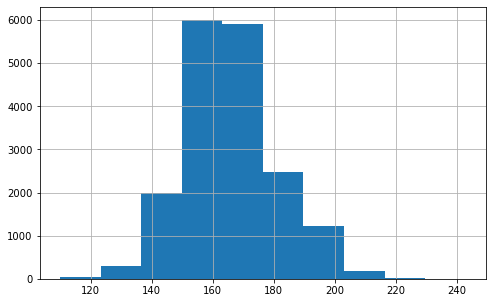

In [10]:
fig = plt.figure(figsize = (8,5))
ax = fig.gca()
data["Weight"].hist(ax = ax)
fig.savefig(output_dir + "weight_hist.png")

## BMI: Body Mass Index

In [11]:
data['BMI'] = (data['Weight'] * 0.45359237) /  ((data['Height']/100)**2)

## Currency
#### Check NaN values

In [12]:
idx = data['Release Clause'].isnull()
idx = data[idx].index
data = data.drop(index=idx)
print(len(idx), 'dropped !')

1516 dropped !


In [13]:
def transform_currency(x):
    if x == -1:
        print('error', x)        
        return -1
            
    # remove symbol
    if str(x[0]) != '€':
        print('error', x)        
    x = x[1:]

    if x[-1] == 'K':
        x = float(x[:-1]) * 1000
    elif x[-1] == 'M':
        x = float(x[:-1]) * 1000000
        
    return x

In [14]:
# transform
data['Value'] = data['Value'].map(transform_currency).astype(float)
data['Wage'] = data['Wage'].map(transform_currency).astype(float)
data['Release Clause'] = data['Release Clause'].map(transform_currency).astype(float)

## Position groups

In [15]:
print(len(data['Position'].value_counts()))
data['Position'].value_counts()

27


ST     1924
GK     1900
CB     1646
CM     1276
LB     1223
RB     1199
RM     1022
LM     1012
CAM     877
CDM     873
RCB     615
LCB     595
RCM     355
LCM     353
LW      338
RW      325
RDM     228
LDM     224
LS      184
RS      179
RWB      84
LWB      76
CF       66
RAM      21
LAM      20
LF       15
RF       13
Name: Position, dtype: int64

In [16]:
# https://pxilok.ru/threads/fifa-20-positions-ids.593/
def_pos = [
    'RWB', 'RB', 'RCB', 'CB', 'LCB', 'LB', 'LWB'
]
mid_pos = [
    'RDM', 'CDM', 'LDM', 'RM', 'RCM', 'CM', 'LCM', 'LM', 
    'RAM', 'CAM', 'LAM'
]
fwd_pos = [
    'RF', 'CF', 'LF', 'RW', 'RS', 'ST', 'LS', 'LW'
]

def transform_position(x):
    if x in def_pos:
        return 'DEF'
    elif x in mid_pos:
        return 'MID'
    elif x in fwd_pos:
        return 'FWD'
    elif x == 'GK':
        return 'GK'
    else:
        print("error:", x)
        return 'unknown'

In [17]:
data['NPosition'] = data['Position'].map(transform_position)
data['NPosition'].value_counts()

MID    6261
DEF    5438
FWD    3044
GK     1900
Name: NPosition, dtype: int64

## Stats

In [18]:
stat_col = [
    'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
    'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
    'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'
]

#### Check NaN

In [19]:
for col in stat_col:
    idx = data[col].isnull()
    idx = data[idx].index
    print(col, len(idx))
    data = data.drop(index=idx)
data

LS 1900
ST 0
RS 0
LW 0
LF 0
CF 0
RF 0
RW 0
LAM 0
CAM 0
RAM 0
LM 0
LCM 0
CM 0
RCM 0
RM 0
LWB 0
LDM 0
CDM 0
RDM 0
RWB 0
LB 0
LCB 0
CB 0
RCB 0
RB 0


,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,BMI,NPosition
0,L. Messi,30-35,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,10.0,"Jul 1, 2004",NaN,2021,170.2,159,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,24.896813,FWD
1,Cristiano Ronaldo,30-35,Portugal,94,94,Juventus,77000000.0,405000.0,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,7.0,"Jul 10, 2018",NaN,2022,188.0,183,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,23.485571,FWD
2,Neymar Jr,25-30,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,10.0,"Aug 3, 2017",NaN,2022,175.3,150,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,22.140793,FWD
4,K. De Bruyne,25-30,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,7.0,"Aug 30, 2015",NaN,2023,180.3,154,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,21.487951,MID
5,E. Hazard,25-30,Belgium,91,91,Chelsea,93000000.0,340000.0,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,LF,10.0,"Jul 1, 2012",NaN,2020,172.7,163,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,89+3,66+3,63+3,63+3,63+3,66+3,60+3,49+3,49+3,49+3,60+3,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172100000.0,24.789552,FWD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,-20,England,47,65,Crewe Alexandra,60000.0,1000.0,1307,Right,1.0,2.0,2.0,Medium/ Medium,Lean,CM,22.0,"May 3, 2017",NaN,2019,175.3,134,42+2,42+2,42+2,44+2,44+2,44+2,44+2,44+2,45+2,45+2,45+2,44+2,45+2,45+2,45+2,44+2,44+2,45+2,45+2,45+2,44+2,45+2,45+2,45+2,45+2,45+2,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,143000.0,19.779108,MID
18203,N. Christoffersson,-20,Sweden,47,63,Trelleborgs FF,60000.0,1000.0,1098,Right,1.0,2.0,2.0,Medium

In [20]:
# remove value stat+value in stat col
def clean_stat(x):
    if len(str(x)) > 0:
        #print(x, str(x).split('+')[0])
        return str(x).split('+')[0]

In [21]:
for col in stat_col:
    data[col] = data[col].map(clean_stat).astype(int)

In [22]:
data['NPosition'].value_counts()

MID    6261
DEF    5438
FWD    3044
Name: NPosition, dtype: int64

# Body Type

In [23]:
data['Body Type'].value_counts()

Normal                 8374
Lean                   5440
Stocky                  923
Messi                     1
C. Ronaldo                1
Neymar                    1
PLAYER_BODY_TYPE_25       1
Shaqiri                   1
Akinfenwa                 1
Name: Body Type, dtype: int64

In [24]:
data['Body Type'].loc[data['Body Type'].isin(['C. Ronaldo', 'Akinfenwa', 'Neymar','Shaqiri', 'PLAYER_BODY_TYPE_25', 'Courtois', 'Messi'])] = 'Unknown'
data['Body Type'].value_counts()

/opt/anaconda/envs/SD/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Normal     8374
Lean       5440
Stocky      923
Unknown       6
Name: Body Type, dtype: int64

In [25]:
data_clean = data.copy()

# drop all stats

corr_drops = def_pos + mid_pos + fwd_pos
corr_drops += [
    'Release Clause',
    'StandingTackle',
    'SlidingTackle',
    'GKDiving',
    'GKHandling',
    'GKKicking',
    'GKPositioning',
    'GKReflexes',
]

data_clean = data_clean.drop(corr_drops, axis=1)
data_clean

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,BMI,NPosition
0,L. Messi,30-35,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Unknown,RF,10.0,"Jul 1, 2004",NaN,2021,170.2,159,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,24.896813,FWD
1,Cristiano Ronaldo,30-35,Portugal,94,94,Juventus,77000000.0,405000.0,2228,Right,5.0,4.0,5.0,High/ Low,Unknown,ST,7.0,"Jul 10, 2018",NaN,2022,188.0,183,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,23.485571,FWD
2,Neymar Jr,25-30,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,Right,5.0,5.0,5.0,High/ Medium,Unknown,LW,10.0,"Aug 3, 2017",NaN,2022,175.3,150,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,22.140793,FWD
4,K. De Bruyne,25-30,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,7.0,"Aug 30, 2015",NaN,2023,180.3,154,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,21.487951,MID
5,E. Hazard,25-30,Belgium,91,91,Chelsea,93000000.0,340000.0,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,LF,10.0,"Jul 1, 2012",NaN,2020,172.7,163,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,24.789552,FWD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,-20,England,47,65,Crewe Alexandra,60000.0,1000.0,1307,Right,1.0,2.0,2.0,Medium/ Medium,Lean,CM,22.0,"May 3, 2017",NaN,2019,175.3,134,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,19.779108,MID
18203,N. Christoffersson,-20,Sweden,47,63,Trelleborgs FF,60000.0,1000.0,1098,Right,1.0,2.0,2.0,Medium/ Medium,Normal,ST,21.0,"Mar 19, 2018",NaN,2020,190.5,170,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,21.248325,FWD
18204,B. Worman,-20,England,47,67,Cambridge United,60000.0,1000.0,1189,Right,1.0,3.0,2.0,Medium/ Medium,Normal,ST,33.0,"Jul 1, 2017",NaN,2021,172.7,148,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,22.508304,FWD
18205,D. Walker-Rice,-20,England,47,66,Tranmere Rovers,60000.0,1000.0,1228,Right,1.0,3.0,2.0,Medium/ Medium,Lean,RW,34.0,"Apr 24, 2018",NaN,2019,177.8,154,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,22.096473,FWD


# AutoML

In [26]:
data_aml = data_clean.copy()

pred_drops = [
    'Name',
    'Nationality',
    'Club',
    'Position',
    'Joined',
    'Contract Valid Until',
    'Loaned From'
]

data_aml = data_aml.drop(pred_drops, axis=1)

dummy_cols = [
    'Age',
    'Work Rate',
    'Preferred Foot',
    'Body Type',
    'NPosition',
]

for col in dummy_cols:
    data_aml[col] = data_aml[col].astype('category').cat.codes
data_aml

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Jersey Number,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,BMI,NPosition
0,4,94,94,110500000.0,565000.0,2202,0,5.0,4.0,4.0,8,3,10.0,170.2,159,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,24.896813,1
1,4,94,94,77000000.0,405000.0,2228,1,5.0,4.0,5.0,1,3,7.0,188.0,183,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,23.485571,1
2,3,92,93,118500000.0,290000.0,2143,1,5.0,5.0,5.0,2,3,10.0,175.3,150,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,22.140793,1
4,3,91,92,102000000.0,355000.0,2281,1,4.0,5.0,4.0,0,1,7.0,180.3,154,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,21.487951,2
5,3,91,91,93000000.0,340000.0,2142,1,4.0,4.0,4.0,2,1,10.0,172.7,163,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,24.789552,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,1,47,65,60000.0,1000.0,1307,1,1.0,2.0,2.0,8,0,22.0,175.3,134,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,19.779108,2
18203,1,47,63,60000.0,1000.0,1098,1,1.0,2.0,2.0,8,1,21.0,190.5,170,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,21.248325,1
18204,1,47,67,60000.0,1000.0,1189,1,1.0,3.0,2.0,8,1,33.0,172.7,148,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,22.508304,1
18205,1,47,66,60000.0,1000.0,1228,1,1.0,3.0,2.0,8,0,34.0,177.8,154,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,22.096473,1


In [27]:
X_value = data_aml.drop(['Value'], axis=1)
y_value = data_aml['Value']

X_V_train, X_V_test, y_V_train, y_V_test = train_test_split(X_value, y_value, random_state=random_state)

In [28]:
budget = 5 * 60

# skf = StratifiedKFold(n_splits=10)

clf_aml = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task = budget,
    per_run_time_limit = int(budget/5),
    # tmp_folder=output_dir + "AutoSklearnRegressor",
    # resampling_strategy=skf,
    resampling_strategy='cv', 
    resampling_strategy_arguments={'folds': 10},
    # scoring_functions = [metrics.r2_score, metrics.precision_score],
    # ensemble_size = 3 
)

In [29]:
clf_aml.fit(X_V_train, y_V_train)

[WARNING] [2022-01-10 19:35:27,301:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2022-01-10 19:35:50,656:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1


AutoSklearnRegressor(per_run_time_limit=60, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 10},
                     time_left_for_this_task=300)

In [30]:
print(clf_aml.sprint_statistics())

auto-sklearn results:
  Dataset name: dea1d9fd-7243-11ec-95dc-adff35704611
  Metric: r2
  Best validation score: 0.977154
  Number of target algorithm runs: 8
  Number of successful target algorithm runs: 2
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 2



In [48]:
df_cv_results = pd.DataFrame(clf_aml.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(df_cv_results.T.to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &                                                  3 &                                                  0 &                                                  2 &                                                  4 &                                                  5 &                                                  6 &                                                  7 &                                                  1 \\
\midrule
mean\_test\_score                                    &                                           0.977154 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                           -0.00089 \\
mean\_fit\_time                              

In [32]:
clf_aml.leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
5,1,1.0,gradient_boosting,0.022846,32.827184,4,0.000069,0,1.641840e+09,1.641840e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],None,Initial design


In [49]:
print(clf_aml.leaderboard(detailed=True).to_latex())

\begin{tabular}{lrrlrrrrrrrrlllll}
\toprule
{} &  rank &  ensemble\_weight &               type &      cost &   duration &  config\_id &  train\_loss &  seed &    start\_time &      end\_time &  budget &              status & data\_preprocessors & feature\_preprocessors & balancing\_strategy &   config\_origin \\
model\_id &       &                  &                    &           &            &            &             &       &               &               &         &                     &                    &                       &                    &                 \\
\midrule
5        &     1 &              1.0 &  gradient\_boosting &  0.022846 &  32.827184 &          4 &    0.000069 &     0 &  1.641840e+09 &  1.641840e+09 &     0.0 &  StatusType.SUCCESS &                 [] &    [no\_preprocessing] &               None &  Initial design \\
\bottomrule
\end{tabular}



In [33]:
print(clf_aml.show_models())

[(1.000000, SimpleRegressionPipeline({'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'gradient_boosting', 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'regressor:gradient_boosting:early_stop': 'off', 'regressor:gradient_boosting:l2_regularization': 5.997418027353535e-10, 'regressor:gradient_boosting:learning_rate': 0.12286466971783992, 'regressor:gradient_boosting:loss': 'least_squares', 'regressor:gradient_boosting:max_bins': 255, 'regressor:gradient_boosting:max_depth': 'None', 'regressor:gradient_boosting:max_leaf_nodes': 26, 'regressor:gradient_boosting

In [34]:
train_predictions = clf_aml.predict(X_V_train)
print("Train R2 score:", metrics.r2_score(y_V_train, train_predictions))
test_predictions = clf_aml.predict(X_V_test)
print("Test R2 score:", metrics.r2_score(y_V_test, test_predictions))

Train R2 score: 0.9996667885136841
Test R2 score: 0.9790015298850543


## Wage

In [39]:
X_wage = data_aml.drop(['Wage'], axis=1)
y_wage = data_aml['Wage'].astype(int)

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wage,y_wage,test_size=.3, random_state=random_state)

In [40]:
clf_aml2 = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task = budget,
    per_run_time_limit = int(budget/5),
    # tmp_folder=output_dir + "AutoSklearnRegressor",
    # resampling_strategy=skf,
    resampling_strategy='cv', 
    resampling_strategy_arguments={'folds': 10},
    # scoring_functions = [metrics.r2_score, metrics.precision_score],
    # ensemble_size = 3 
)
clf_aml2.fit(X_train_w, y_train_w)

AutoSklearnRegressor(per_run_time_limit=60, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 10},
                     time_left_for_this_task=300)

In [41]:
print(clf_aml2.sprint_statistics())

auto-sklearn results:
  Dataset name: 60eacd61-7245-11ec-95dc-adff35704611
  Metric: r2
  Best validation score: 0.750079
  Number of target algorithm runs: 7
  Number of successful target algorithm runs: 2
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 1



In [42]:
df_cv_results2 = pd.DataFrame(clf_aml2.cv_results_).sort_values(by='mean_test_score', ascending=False)
df_cv_results2

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,param_regressor:__choice__,param_data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__,param_data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__,param_data_preprocessor:feature_type:numerical_transformer:imputation:strategy,param_data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__,param_feature_preprocessor:extra_trees_preproc_for_regression:bootstrap,param_feature_preprocessor:extra_trees_preproc_for_regression:criterion,param_feature_preprocessor:extra_trees_preproc_for_regression:max_depth,param_feature_preprocessor:extra_trees_preproc_for_regression:max_features,param_feature_preprocessor:extra_trees_preproc_for_regression:max_leaf_nodes,param_feature_preprocessor:extra_trees_preproc_for_regression:min_samples_leaf,param_feature_preprocessor:extra_trees_preproc_for_regression:min_samples_split,param_feature_preprocessor:extra_trees_preproc_for_regression:min_weight_fraction_leaf,param_feature_preprocessor:extra_trees_preproc_for_regression:n_estimators,param_feature_preprocessor:fast_ica:algorithm,param_feature_preprocessor:fast_ica:fun,param_feature_preprocessor:fast_ica:whiten,param_feature_preprocessor:feature_agglomeration:affinity,param_feature_preprocessor:feature_agglomeration:linkage,param_feature_preprocessor:feature_agglomeration:n_clusters,param_feature_preprocessor:feature_agglomeration:pooling_func,param_feature_preprocessor:kernel_pca:kernel,param_feature_preprocessor:kernel_pca:n_components,param_feature_preprocessor:kitchen_sinks:gamma,param_feature_preprocessor:kitchen_sinks:n_components,param_feature_preprocessor:nystroem_sampler:kernel,param_feature_preprocessor:nystroem_sampler:n_components,param_feature_preprocessor:pca:keep_variance,param_feature_preprocessor:pca:whiten,param_feature_preprocessor:polynomial:degree,param_feature_preprocessor:polynomial:include_bias,param_feature_preprocessor:polynomial:interaction_only,param_feature_preprocessor:random_trees_embedding:bootstrap,param_feature_preprocessor:random_trees_embedding:max_depth,param_feature_preprocessor:random_trees_embedding:max_leaf_nodes,param_feature_preprocessor:random_trees_embedding:min_samples_leaf,param_feature_preprocessor:random_trees_embedding:min_samples_split,param_feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf,param_feature_preprocessor:random_trees_embedding:n_estimators,param_feature_preprocessor:select_percentile_regression:percentile,param_feature_preprocessor:select_percentile_regression:score_func,param_feature_preprocessor:select_rates_regression:alpha,...,param_regressor:mlp:batch_size,param_regressor:mlp:beta_1,param_regressor:mlp:beta_2,param_regressor:mlp:early_stopping,param_regressor:mlp:epsilon,param_regressor:mlp:hidden_layer_depth,param_regressor:mlp:learning_rate_init,param_regressor:mlp:n_iter_no_change,param_regressor:mlp:num_nodes_per_layer,param_regressor:mlp:shuffle,param_regressor:mlp:solver,param_regressor:mlp:tol,param_regressor:random_forest:bootstrap,param_regressor:random_forest:criterion,param_regressor:random_forest:max_depth,param_regressor:random_forest:max_features,param_regressor:random_forest:max_leaf_nodes,param_regressor:random_forest:min_impurity_decrease,param_regressor:random_forest:min_samples_leaf,param_regressor:random_forest:min_samples_split,param_regressor:random_forest:min_weight_fraction_leaf,param_regressor:sgd:alpha,param_regressor:sgd:average,param_regressor:sgd:fit_intercept,param_regressor:sgd:learning_rate,param_regressor:sgd:loss,param_regressor:sgd:penalty,param_regressor:sgd:tol,param_data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction,param_data_preprocessor:feature_type:numerical_transformer:rescaling:quantile_transformer:n_quantiles,param_data_preprocessor:fea

In [59]:
print(df_cv_results2.T.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &                                                  3 &                                                  0 &                                                  1 &                                                  4 &                                                  5 &                                                  6 &                                                  2 \\
\midrule
mean\_test\_score                                    &                                           0.750079 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                          -0.001049 \\
mean\_fit\_time                                      &                                          29.304173 &                                          60.

In [55]:
clf_aml2.leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
5,1,0.96,gradient_boosting,0.249921,29.304173,4,0.003023,0,1.641840e+09,1.641840e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],None,Initial design
4,2,0.04,ard_regression,1.001049,39.363339,3,1.000000,0,1.641840e+09,1.641840e+09,0.0,StatusType.SUCCESS,[],[polynomial],None,Initial design


In [56]:
print(clf_aml2.leaderboard(detailed=True).to_latex())

\begin{tabular}{lrrlrrrrrrrrlllll}
\toprule
{} &  rank &  ensemble\_weight &               type &      cost &   duration &  config\_id &  train\_loss &  seed &    start\_time &      end\_time &  budget &              status & data\_preprocessors & feature\_preprocessors & balancing\_strategy &   config\_origin \\
model\_id &       &                  &                    &           &            &            &             &       &               &               &         &                     &                    &                       &                    &                 \\
\midrule
5        &     1 &             0.96 &  gradient\_boosting &  0.249921 &  29.304173 &          4 &    0.003023 &     0 &  1.641840e+09 &  1.641840e+09 &     0.0 &  StatusType.SUCCESS &                 [] &    [no\_preprocessing] &               None &  Initial design \\
4        &     2 &             0.04 &     ard\_regression &  1.001049 &  39.363339 &          3 &    1.000000 &     0 &  1.641840e+09 &  

In [58]:
train_predictions2 = clf_aml2.predict(X_train_w)
print("Train R2 score:", metrics.r2_score(y_train_w, train_predictions2))
test_predictions2 = clf_aml2.predict(X_test_w)
print("Test R2 score:", metrics.r2_score(y_test_w, test_predictions2))

Train R2 score: 0.9898922712503859
Test R2 score: 0.8023640710253628


## Overall

In [50]:
X_overall = data_aml.drop(['Overall'], axis=1)
y_overall = data_aml['Overall'].astype(int)

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_overall,y_overall,test_size=.3, random_state=random_state)

In [51]:
clf_aml3 = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task = budget,
    per_run_time_limit = int(budget/5),
    # tmp_folder=output_dir + "AutoSklearnRegressor",
    # resampling_strategy=skf,
    resampling_strategy='cv', 
    resampling_strategy_arguments={'folds': 10},
    # scoring_functions = [metrics.r2_score, metrics.precision_score],
    # ensemble_size = 3 
)
clf_aml3.fit(X_train_o, y_train_o)

AutoSklearnRegressor(per_run_time_limit=60, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 10},
                     time_left_for_this_task=300)

In [60]:
print(clf_aml3.sprint_statistics())

auto-sklearn results:
  Dataset name: b1640e16-7249-11ec-95dc-adff35704611
  Metric: r2
  Best validation score: 0.993811
  Number of target algorithm runs: 6
  Number of successful target algorithm runs: 1
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 0



In [67]:
clf_aml3.leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
5,1,1.0,gradient_boosting,0.006189,32.75276,4,0.000536,0,1.641842e+09,1.641842e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],None,Initial design


In [68]:
print(clf_aml3.leaderboard(detailed=True).to_latex())

\begin{tabular}{lrrlrrrrrrrrlllll}
\toprule
{} &  rank &  ensemble\_weight &               type &      cost &  duration &  config\_id &  train\_loss &  seed &    start\_time &      end\_time &  budget &              status & data\_preprocessors & feature\_preprocessors & balancing\_strategy &   config\_origin \\
model\_id &       &                  &                    &           &           &            &             &       &               &               &         &                     &                    &                       &                    &                 \\
\midrule
5        &     1 &              1.0 &  gradient\_boosting &  0.006189 &  32.75276 &          4 &    0.000536 &     0 &  1.641842e+09 &  1.641842e+09 &     0.0 &  StatusType.SUCCESS &                 [] &    [no\_preprocessing] &               None &  Initial design \\
\bottomrule
\end{tabular}



In [61]:
df_cv_results3 = pd.DataFrame(clf_aml3.cv_results_).sort_values(by='mean_test_score', ascending=False)
df_cv_results3

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,param_regressor:__choice__,param_data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__,param_data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__,param_data_preprocessor:feature_type:numerical_transformer:imputation:strategy,param_data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__,param_feature_preprocessor:extra_trees_preproc_for_regression:bootstrap,param_feature_preprocessor:extra_trees_preproc_for_regression:criterion,param_feature_preprocessor:extra_trees_preproc_for_regression:max_depth,param_feature_preprocessor:extra_trees_preproc_for_regression:max_features,param_feature_preprocessor:extra_trees_preproc_for_regression:max_leaf_nodes,param_feature_preprocessor:extra_trees_preproc_for_regression:min_samples_leaf,param_feature_preprocessor:extra_trees_preproc_for_regression:min_samples_split,param_feature_preprocessor:extra_trees_preproc_for_regression:min_weight_fraction_leaf,param_feature_preprocessor:extra_trees_preproc_for_regression:n_estimators,param_feature_preprocessor:fast_ica:algorithm,param_feature_preprocessor:fast_ica:fun,param_feature_preprocessor:fast_ica:whiten,param_feature_preprocessor:feature_agglomeration:affinity,param_feature_preprocessor:feature_agglomeration:linkage,param_feature_preprocessor:feature_agglomeration:n_clusters,param_feature_preprocessor:feature_agglomeration:pooling_func,param_feature_preprocessor:kernel_pca:kernel,param_feature_preprocessor:kernel_pca:n_components,param_feature_preprocessor:kitchen_sinks:gamma,param_feature_preprocessor:kitchen_sinks:n_components,param_feature_preprocessor:nystroem_sampler:kernel,param_feature_preprocessor:nystroem_sampler:n_components,param_feature_preprocessor:pca:keep_variance,param_feature_preprocessor:pca:whiten,param_feature_preprocessor:polynomial:degree,param_feature_preprocessor:polynomial:include_bias,param_feature_preprocessor:polynomial:interaction_only,param_feature_preprocessor:random_trees_embedding:bootstrap,param_feature_preprocessor:random_trees_embedding:max_depth,param_feature_preprocessor:random_trees_embedding:max_leaf_nodes,param_feature_preprocessor:random_trees_embedding:min_samples_leaf,param_feature_preprocessor:random_trees_embedding:min_samples_split,param_feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf,param_feature_preprocessor:random_trees_embedding:n_estimators,param_feature_preprocessor:select_percentile_regression:percentile,param_feature_preprocessor:select_percentile_regression:score_func,param_feature_preprocessor:select_rates_regression:alpha,...,param_regressor:mlp:batch_size,param_regressor:mlp:beta_1,param_regressor:mlp:beta_2,param_regressor:mlp:early_stopping,param_regressor:mlp:epsilon,param_regressor:mlp:hidden_layer_depth,param_regressor:mlp:learning_rate_init,param_regressor:mlp:n_iter_no_change,param_regressor:mlp:num_nodes_per_layer,param_regressor:mlp:shuffle,param_regressor:mlp:solver,param_regressor:mlp:tol,param_regressor:random_forest:bootstrap,param_regressor:random_forest:criterion,param_regressor:random_forest:max_depth,param_regressor:random_forest:max_features,param_regressor:random_forest:max_leaf_nodes,param_regressor:random_forest:min_impurity_decrease,param_regressor:random_forest:min_samples_leaf,param_regressor:random_forest:min_samples_split,param_regressor:random_forest:min_weight_fraction_leaf,param_regressor:sgd:alpha,param_regressor:sgd:average,param_regressor:sgd:fit_intercept,param_regressor:sgd:learning_rate,param_regressor:sgd:loss,param_regressor:sgd:penalty,param_regressor:sgd:tol,param_data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction,param_data_preprocessor:feature_type:numerical_transformer:rescaling:quantile_transformer:n_quantiles,param_data_preprocessor:fea

In [62]:
print(df_cv_results3.T.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &                                                  3 &                                                  0 &                                                  1 &                                                  2 &                                                  4 &                                                  5 \\
\midrule
mean\_test\_score                                    &                                           0.993811 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 \\
mean\_fit\_time                                      &                                           32.75276 &                                          60.019907 &                                          60.036993 &                                          21.2

In [66]:
train_predictions3 = clf_aml3.predict(X_train_o)
print("Train R2 score:", metrics.r2_score(y_train_o, train_predictions3))
test_predictions3 = clf_aml3.predict(X_test_o)
print("Test R2 score:", metrics.r2_score(y_test_o, test_predictions3))

Train R2 score: 0.9993470987493016
Test R2 score: 0.9948201586947482


# Classification

In [104]:
classif_metrics = [
    auto_metrics.accuracy,
    auto_metrics.balanced_accuracy,
    
    auto_metrics.f1_macro,
    auto_metrics.f1_micro,
    auto_metrics.f1_weighted,
    
    auto_metrics.precision_macro,
    auto_metrics.precision_micro,
    auto_metrics.precision_weighted,
    
    auto_metrics.recall_macro,
    auto_metrics.recall_micro,
    auto_metrics.recall_samples,
]

## DWage

In [63]:
wage_itrvl = [0, 100e1,  300e1,  1000e1, 100000e1]
data_aml["DWage"] = pd.cut(data_aml['Wage'].values, wage_itrvl).astype(str)

X_dwage = data_aml.drop(['DWage', 'Wage'], axis=1)
y_dwage = data_aml['DWage']

X_train_dwa, X_test_dwa, y_train_dwa, y_test_dwa = train_test_split(X_dwage,y_dwage,test_size=.3, random_state=random_state)

In [111]:
clf_aml4 = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task = budget,
    per_run_time_limit = int(budget/5),
    # tmp_folder=output_dir + "AutoSklearnRegressor",
    # resampling_strategy=skf,
    resampling_strategy='cv', 
    resampling_strategy_arguments={'folds': 10},
    scoring_functions = classif_metrics
)

clf_aml4.fit(X_train_dwa, y_train_dwa)

AutoSklearnClassifier(per_run_time_limit=60, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      scoring_functions=[accuracy, balanced_accuracy, f1_macro,
                                         f1_micro, f1_weighted, precision_macro,
                                         precision_micro, precision_weighted,
                                         recall_macro, recall_micro,
                                         recall_samples],
                      time_left_for_this_task=300)

In [112]:
print(clf_aml4.sprint_statistics())

auto-sklearn results:
  Dataset name: 4fbbf242-7256-11ec-95dc-adff35704611
  Metric: accuracy
  Best validation score: 0.621609
  Number of target algorithm runs: 7
  Number of successful target algorithm runs: 2
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 0



In [116]:
clf_aml4.leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
7,1,0.66,gradient_boosting,0.378391,31.091871,6,0.052466,0,1.641848e+09,1.641848e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],weighting,Initial design
6,2,0.34,passive_aggressive,0.403004,9.427623,5,0.389686,0,1.641848e+09,1.641848e+09,0.0,StatusType.SUCCESS,[],[select_rates_classification],weighting,Initial design


In [117]:
print(clf_aml4.leaderboard(detailed=True).to_latex())

\begin{tabular}{lrrlrrrrrrrrlllll}
\toprule
{} &  rank &  ensemble\_weight &                type &      cost &   duration &  config\_id &  train\_loss &  seed &    start\_time &      end\_time &  budget &              status & data\_preprocessors &          feature\_preprocessors & balancing\_strategy &   config\_origin \\
model\_id &       &                  &                     &           &            &            &             &       &               &               &         &                     &                    &                                &                    &                 \\
\midrule
7        &     1 &             0.66 &   gradient\_boosting &  0.378391 &  31.091871 &          6 &    0.052466 &     0 &  1.641848e+09 &  1.641848e+09 &     0.0 &  StatusType.SUCCESS &                 [] &             [no\_preprocessing] &          weighting &  Initial design \\
6        &     2 &             0.34 &  passive\_aggressive &  0.403004 &   9.427623 &          5 &    0.389

In [114]:
df_cv_results4 = pd.DataFrame(clf_aml4.cv_results_).sort_values(by='mean_test_score', ascending=False)
df_cv_results4

,mean_test_score,metric_accuracy,metric_balanced_accuracy,metric_f1_macro,metric_f1_micro,metric_f1_weighted,metric_precision_macro,metric_precision_micro,metric_precision_weighted,metric_recall_macro,metric_recall_micro,metric_recall_samples,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,param_classifier:adaboost:algorithm,param_classifier:adaboost:learning_rate,param_classifier:adaboost:max_depth,param_classifier:adaboost:n_estimators,param_classifier:bernoulli_nb:alpha,param_classifier:bernoulli_nb:fit_prior,param_classifier:decision_tree:criterion,param_classifier:decision_tree:max_depth_factor,param_classifier:decision_tree:max_features,param_classifier:decision_tree:max_leaf_nodes,param_classifier:decision_tree:min_impurity_decrease,param_classifier:decision_tree:min_samples_leaf,param_classifier:decision_tree:min_samples_split,param_classifier:decision_tree:min_weight_fraction_leaf,param_classifier:extra_trees:bootstrap,param_classifier:extra_trees:criterion,param_classifier:extra_trees:max_depth,param_classifier:extra_trees:max_features,param_classifier:extra_trees:max_leaf_nodes,param_classifier:extra_trees:min_impurity_decrease,param_classifier:extra_trees:min_samples_leaf,param_classifier:extra_trees:min_samples_split,param_classifier:extra_trees:min_weight_fraction_leaf,param_classifier:gradient_boosting:early_stop,param_classifier:gradient_boosting:l2_regularization,param_classifier:gradient_boosting:learning_rate,param_classifier:gradient_boosting:loss,param_classifier:gradient_boosting:max_bins,param_classifier:gradient_boosting:max_depth,...,param_feature_preprocessor:kitchen_sinks:n_components,param_feature_preprocessor:liblinear_svc_preprocessor:C,param_feature_preprocessor:liblinear_svc_preprocessor:dual,param_feature_preprocessor:liblinear_svc_preprocessor:fit_intercept,param_feature_preprocessor:liblinear_svc_preprocessor:intercept_scaling,param_feature_preprocessor:liblinear_svc_preprocessor:loss,param_feature_preprocessor:liblinear_svc_preprocessor:multi_class,param_feature_preprocessor:liblinear_svc_preprocessor:penalty,param_feature_preprocessor:liblinear_svc_preprocessor:tol,param_feature_preprocessor:nystroem_sampler:kernel,param_feature_preprocessor:nystroem_sampler:n_components,param_feature_preprocessor:pca:keep_variance,param_feature_preprocessor:pca:whiten,param_feature_preprocessor:polynomial:degree,param_feature_preprocessor:polynomial:include_bias,param_feature_preprocessor:polynomial:interaction_only,param_feature_preprocessor:random_trees_embedding:bootstrap,param_feature_preprocessor:random_trees_embedding:max_depth,param_feature_preprocessor:random_trees_embedding:max_leaf_nodes,param_feature_preprocessor:random_trees_embedding:min_samples_leaf,param_feature_preprocessor:random_trees_embedding:min_samples_split,param_feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf,param_feature_preprocessor:random_trees_embedding:n_estimators,param_feature_preprocessor:select_percentile_classification:percentile,param_feature_preprocessor:select_percentile_classification:score_func,param_feature_preprocessor:select_rates_classification:alpha,param_feature_preprocessor:select_rates_classification:score_func,param_classifier:gradient_boosting:n_iter_no_change,param_classifier:gradient_boosting:validation_fraction,param_classifier:lda:shrinkage_factor,param_classifier:libsvm_svc:coef0,param_classifier:libsvm_svc:degree,param_classifier:mlp:validation_fraction,param_classifier:sgd:epsilon,param_classifier:sgd:eta0,param_classifier:sgd:l1_ratio,param_classifier:sgd:power_t,param_data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction,param_data_preprocessor:feature_type:numerical_transformer:rescaling:quantile_transformer:n_quantiles,param_data_preprocessor:feature_type:numerical_transformer:rescaling:qua

In [122]:
print(df_cv_results4.T.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &                                                  5 &                                                  4 &                                                  0 &                                                  1 &                                                  2 &                                                  3 &                                                  6 \\
\midrule
mean\_test\_score                                    &                                           0.621609 &                                           0.596996 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 \\
metric\_accuracy                                    &                                           0.621609 &                                           0.5

In [119]:
train_predictions4 = clf_aml4.predict(X_train_dwa)
print("accuracy score:", metrics.accuracy_score(y_train_dwa, train_predictions4))
print("--------------------------------------")
print('f1 macro score:', metrics.f1_score(y_train_dwa,train_predictions4, average='macro'))
print('f1 micro score:', metrics.f1_score(y_train_dwa,train_predictions4, average='micro'))
print('f1 weighted score:', metrics.f1_score(y_train_dwa,train_predictions4, average='weighted'))
print("----------------------")
print('recall macro score:', metrics.recall_score(y_train_dwa,train_predictions4, average='macro'))
print('recall micro score:', metrics.recall_score(y_train_dwa,train_predictions4, average='micro'))
print('recall weighted score:', metrics.recall_score(y_train_dwa,train_predictions4, average='weighted'))
print("----------------------")
print('precision macro score:', metrics.precision_score(y_train_dwa,train_predictions4, average='macro'))
print('precision micro score:', metrics.precision_score(y_train_dwa,train_predictions4, average='micro'))
print('precision weighted score:', metrics.precision_score(y_train_dwa,train_predictions4, average='weighted'))
print("----------------------")


test_predictions4 = clf_aml4.predict(X_test_dwa)
print("accuracy score:", metrics.accuracy_score(y_test_dwa, test_predictions4))
print("--------------------------------------")
print('f1 macro score:', metrics.f1_score(y_test_dwa,test_predictions4, average='macro'))
print('f1 micro score:', metrics.f1_score(y_test_dwa,test_predictions4, average='micro'))
print('f1 weighted score:', metrics.f1_score(y_test_dwa,test_predictions4, average='weighted'))
print("----------------------")
print('recall macro score:', metrics.recall_score(y_test_dwa,test_predictions4, average='macro'))
print('recall micro score:', metrics.recall_score(y_test_dwa,test_predictions4, average='micro'))
print('recall weighted score:', metrics.recall_score(y_test_dwa,test_predictions4, average='weighted'))
print("----------------------")
print('precision macro score:', metrics.precision_score(y_test_dwa,test_predictions4, average='macro'))
print('precision micro score:', metrics.precision_score(y_test_dwa,test_predictions4, average='micro'))
print('precision weighted score:', metrics.precision_score(y_test_dwa,test_predictions4, average='weighted'))
print("----------------------")

accuracy score: 0.9357558139534884
--------------------------------------
f1 macro score: 0.935776763645135
f1 micro score: 0.9357558139534884
f1 weighted score: 0.9357928463661489
----------------------
recall macro score: 0.9373796239938907
recall micro score: 0.9357558139534884
recall weighted score: 0.9357558139534884
----------------------
precision macro score: 0.9350460214393139
precision micro score: 0.9357558139534884
precision weighted score: 0.9366796941484165
----------------------
accuracy score: 0.6172281257065341
--------------------------------------
f1 macro score: 0.6198437028957298
f1 micro score: 0.6172281257065341
f1 weighted score: 0.6154167113542864
----------------------
recall macro score: 0.6220106628811788
recall micro score: 0.6172281257065341
recall weighted score: 0.6172281257065341
----------------------
precision macro score: 0.6182314441365113
precision micro score: 0.6172281257065341
precision weighted score: 0.6141847971577743
----------------------


In [136]:
w_age_scores = [
    [
        metrics.accuracy_score(y_train_dwa, train_predictions4),
        
        metrics.f1_score(y_train_dwa,train_predictions4, average='macro'),
        metrics.f1_score(y_train_dwa,train_predictions4, average='micro'),
        metrics.f1_score(y_train_dwa,train_predictions4, average='weighted'),
        
        metrics.recall_score(y_train_dwa,train_predictions4, average='macro'),
        metrics.recall_score(y_train_dwa,train_predictions4, average='micro'),
        metrics.recall_score(y_train_dwa,train_predictions4, average='weighted'),
        
        metrics.precision_score(y_train_dwa,train_predictions4, average='macro'),
        metrics.precision_score(y_train_dwa,train_predictions4, average='micro'),
        metrics.precision_score(y_train_dwa,train_predictions4, average='weighted'),
        
    ],
    [
        metrics.accuracy_score(y_test_dwa, test_predictions4),
        
        metrics.f1_score(y_test_dwa,test_predictions4, average='macro'),
        metrics.f1_score(y_test_dwa,test_predictions4, average='micro'),
        metrics.f1_score(y_test_dwa,test_predictions4, average='weighted'),
        
        metrics.recall_score(y_test_dwa,test_predictions4, average='macro'),
        metrics.recall_score(y_test_dwa,test_predictions4, average='micro'),
        metrics.recall_score(y_test_dwa,test_predictions4, average='weighted'),
        
        metrics.precision_score(y_test_dwa,test_predictions4, average='macro'),
        metrics.precision_score(y_test_dwa,test_predictions4, average='micro'),
        metrics.precision_score(y_test_dwa,test_predictions4, average='weighted'),
    ]
]

score_cols = [
    'accuracy',
    
    'f1_macro',
    'f1_micro',
    'f1_weighted',
    
    'recall_macro',
    'recall_micro',
    'recall_weighted',
    
    'precision_macro',
    'precision_micro',
    'precision_weighted',
    
    
]
wage_scores = pd.DataFrame(w_age_scores, index=['train', 'test'], columns=score_cols)
wage_scores

,accuracy,f1_macro,f1_micro,f1_weighted,recall_macro,recall_micro,recall_weighted,precision_macro,precision_micro,precision_weighted
train,0.935756,0.935777,0.935756,0.935793,0.937380,0.935756,0.935756,0.935046,0.935756,0.936680
test,0.617228,0.619844,0.617228,0.615417,0.622011,0.617228,0.617228,0.618231,0.617228,0.614185


In [137]:
print(wage_scores.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  accuracy &  f1\_macro &  f1\_micro &  f1\_weighted &  recall\_macro &  recall\_micro &  recall\_weighted &  precision\_macro &  precision\_micro &  precision\_weighted \\
\midrule
train &  0.935756 &  0.935777 &  0.935756 &     0.935793 &      0.937380 &      0.935756 &         0.935756 &         0.935046 &         0.935756 &            0.936680 \\
test  &  0.617228 &  0.619844 &  0.617228 &     0.615417 &      0.622011 &      0.617228 &         0.617228 &         0.618231 &         0.617228 &            0.614185 \\
\bottomrule
\end{tabular}



## DValue

In [130]:
t = 100000

value_itrvl_3 = [0, t*10, t*100, t*10000]
value_itrvl_4 = [0, t*5, t*10, t*100, t*10000]
value_itrvl_6 = [0, t*3, t*6, t*10, t*50, t*100, t*10000]

data_aml["DValue_3"] = pd.cut(data_aml['Value'].values, value_itrvl_3).astype(str)
data_aml["DValue_4"] = pd.cut(data_aml['Value'].values, value_itrvl_4).astype(str)
data_aml["DValue_6"] = pd.cut(data_aml['Value'].values, value_itrvl_6).astype(str)

X_dvalue3 = data_aml.drop(['DWage', 'Value', 'DValue_3', 'DValue_4', 'DValue_6'], axis=1)
y_dvalue3 = data_aml['DValue_3']

X_dvalue4 = data_aml.drop(['DWage', 'Value', 'DValue_3', 'DValue_4', 'DValue_6'], axis=1)
y_dvalue4 = data_aml['DValue_4']

X_dvalue6 = data_aml.drop(['DWage', 'Value', 'DValue_3', 'DValue_4', 'DValue_6'], axis=1)
y_dvalue6 = data_aml['DValue_6']

X_train_dv3, X_test_dv3, y_train_dv3, y_test_dv3 = train_test_split(X_dvalue3,y_dvalue3,test_size=.3, random_state=random_state)
X_train_dv4, X_test_dv4, y_train_dv4, y_test_dv4 = train_test_split(X_dvalue4,y_dvalue4,test_size=.3, random_state=random_state)
X_train_dv6, X_test_dv6, y_train_dv6, y_test_dv6 = train_test_split(X_dvalue6,y_dvalue6,test_size=.3, random_state=random_state)

In [131]:
X_dvalue3

,Age,Overall,Potential,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Jersey Number,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,BMI,NPosition
0,4,94,94,565000.0,2202,0,5.0,4.0,4.0,8,3,10.0,170.2,159,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,24.896813,1
1,4,94,94,405000.0,2228,1,5.0,4.0,5.0,1,3,7.0,188.0,183,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,23.485571,1
2,3,92,93,290000.0,2143,1,5.0,5.0,5.0,2,3,10.0,175.3,150,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,22.140793,1
4,3,91,92,355000.0,2281,1,4.0,5.0,4.0,0,1,7.0,180.3,154,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,21.487951,2
5,3,91,91,340000.0,2142,1,4.0,4.0,4.0,2,1,10.0,172.7,163,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,24.789552,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,1,47,65,1000.0,1307,1,1.0,2.0,2.0,8,0,22.0,175.3,134,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,19.779108,2
18203,1,47,63,1000.0,1098,1,1.0,2.0,2.0,8,1,21.0,190.5,170,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,21.248325,1
18204,1,47,67,1000.0,1189,1,1.0,3.0,2.0,8,1,33.0,172.7,148,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,22.508304,1
18205,1,47,66,1000.0,1228,1,1.0,3.0,2.0,8,0,34.0,177.8,154,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,22.096473,1


## DValue3

In [133]:
clf_aml5 = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task = budget,
    per_run_time_limit = int(budget/5),
    # tmp_folder=output_dir + "AutoSklearnRegressor",
    # resampling_strategy=skf,
    resampling_strategy='cv', 
    resampling_strategy_arguments={'folds': 10},
    scoring_functions = classif_metrics
)

clf_aml5.fit(X_train_dv3, y_train_dv3)

AutoSklearnClassifier(per_run_time_limit=60, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      scoring_functions=[accuracy, balanced_accuracy, f1_macro,
                                         f1_micro, f1_weighted, precision_macro,
                                         precision_micro, precision_weighted,
                                         recall_macro, recall_micro,
                                         recall_samples],
                      time_left_for_this_task=300)

In [138]:
print(clf_aml5.sprint_statistics())

auto-sklearn results:
  Dataset name: cb906652-725b-11ec-95dc-adff35704611
  Metric: accuracy
  Best validation score: 0.980426
  Number of target algorithm runs: 6
  Number of successful target algorithm runs: 1
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 0



In [139]:
clf_aml5.leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
4,1,1.0,gradient_boosting,0.019574,21.680902,3,0.002821,0,1.641850e+09,1.641850e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],weighting,Initial design


In [140]:
print(clf_aml5.leaderboard(detailed=True).to_latex())

\begin{tabular}{lrrlrrrrrrrrlllll}
\toprule
{} &  rank &  ensemble\_weight &               type &      cost &   duration &  config\_id &  train\_loss &  seed &    start\_time &      end\_time &  budget &              status & data\_preprocessors & feature\_preprocessors & balancing\_strategy &   config\_origin \\
model\_id &       &                  &                    &           &            &            &             &       &               &               &         &                     &                    &                       &                    &                 \\
\midrule
4        &     1 &              1.0 &  gradient\_boosting &  0.019574 &  21.680902 &          3 &    0.002821 &     0 &  1.641850e+09 &  1.641850e+09 &     0.0 &  StatusType.SUCCESS &                 [] &    [no\_preprocessing] &          weighting &  Initial design \\
\bottomrule
\end{tabular}



In [141]:
df_cv_results5 = pd.DataFrame(clf_aml5.cv_results_).sort_values(by='mean_test_score', ascending=False)
df_cv_results5

,mean_test_score,metric_accuracy,metric_balanced_accuracy,metric_f1_macro,metric_f1_micro,metric_f1_weighted,metric_precision_macro,metric_precision_micro,metric_precision_weighted,metric_recall_macro,metric_recall_micro,metric_recall_samples,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,param_classifier:adaboost:algorithm,param_classifier:adaboost:learning_rate,param_classifier:adaboost:max_depth,param_classifier:adaboost:n_estimators,param_classifier:bernoulli_nb:alpha,param_classifier:bernoulli_nb:fit_prior,param_classifier:decision_tree:criterion,param_classifier:decision_tree:max_depth_factor,param_classifier:decision_tree:max_features,param_classifier:decision_tree:max_leaf_nodes,param_classifier:decision_tree:min_impurity_decrease,param_classifier:decision_tree:min_samples_leaf,param_classifier:decision_tree:min_samples_split,param_classifier:decision_tree:min_weight_fraction_leaf,param_classifier:extra_trees:bootstrap,param_classifier:extra_trees:criterion,param_classifier:extra_trees:max_depth,param_classifier:extra_trees:max_features,param_classifier:extra_trees:max_leaf_nodes,param_classifier:extra_trees:min_impurity_decrease,param_classifier:extra_trees:min_samples_leaf,param_classifier:extra_trees:min_samples_split,param_classifier:extra_trees:min_weight_fraction_leaf,param_classifier:gradient_boosting:early_stop,param_classifier:gradient_boosting:l2_regularization,param_classifier:gradient_boosting:learning_rate,param_classifier:gradient_boosting:loss,param_classifier:gradient_boosting:max_bins,param_classifier:gradient_boosting:max_depth,...,param_feature_preprocessor:kitchen_sinks:n_components,param_feature_preprocessor:liblinear_svc_preprocessor:C,param_feature_preprocessor:liblinear_svc_preprocessor:dual,param_feature_preprocessor:liblinear_svc_preprocessor:fit_intercept,param_feature_preprocessor:liblinear_svc_preprocessor:intercept_scaling,param_feature_preprocessor:liblinear_svc_preprocessor:loss,param_feature_preprocessor:liblinear_svc_preprocessor:multi_class,param_feature_preprocessor:liblinear_svc_preprocessor:penalty,param_feature_preprocessor:liblinear_svc_preprocessor:tol,param_feature_preprocessor:nystroem_sampler:kernel,param_feature_preprocessor:nystroem_sampler:n_components,param_feature_preprocessor:pca:keep_variance,param_feature_preprocessor:pca:whiten,param_feature_preprocessor:polynomial:degree,param_feature_preprocessor:polynomial:include_bias,param_feature_preprocessor:polynomial:interaction_only,param_feature_preprocessor:random_trees_embedding:bootstrap,param_feature_preprocessor:random_trees_embedding:max_depth,param_feature_preprocessor:random_trees_embedding:max_leaf_nodes,param_feature_preprocessor:random_trees_embedding:min_samples_leaf,param_feature_preprocessor:random_trees_embedding:min_samples_split,param_feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf,param_feature_preprocessor:random_trees_embedding:n_estimators,param_feature_preprocessor:select_percentile_classification:percentile,param_feature_preprocessor:select_percentile_classification:score_func,param_feature_preprocessor:select_rates_classification:alpha,param_feature_preprocessor:select_rates_classification:score_func,param_classifier:gradient_boosting:n_iter_no_change,param_classifier:gradient_boosting:validation_fraction,param_classifier:lda:shrinkage_factor,param_classifier:libsvm_svc:coef0,param_classifier:libsvm_svc:degree,param_classifier:mlp:validation_fraction,param_classifier:sgd:epsilon,param_classifier:sgd:eta0,param_classifier:sgd:l1_ratio,param_classifier:sgd:power_t,param_data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction,param_data_preprocessor:feature_type:numerical_transformer:rescaling:quantile_transformer:n_quantiles,param_data_preprocessor:feature_type:numerical_transformer:rescaling:qua

In [142]:
print(df_cv_results5.T.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &                                                  2 &                                                  0 &                                                  1 &                                                  3 &                                                  4 &                                                  5 \\
\midrule
mean\_test\_score                                    &                                           0.980426 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 \\
metric\_accuracy                                    &                                           0.980426 &                                                NaN &                                                NaN &                                               

In [145]:
train_predictions5 = clf_aml5.predict(X_train_dv3)
test_predictions5 = clf_aml5.predict(X_test_dv3)

dvalue4_scores = [
    [
        metrics.accuracy_score(y_train_dv3, train_predictions5),
        
        metrics.f1_score(y_train_dv3,train_predictions5, average='macro'),
        metrics.f1_score(y_train_dv3,train_predictions5, average='micro'),
        metrics.f1_score(y_train_dv3,train_predictions5, average='weighted'),
        
        metrics.recall_score(y_train_dv3,train_predictions5, average='macro'),
        metrics.recall_score(y_train_dv3,train_predictions5, average='micro'),
        metrics.recall_score(y_train_dv3,train_predictions5, average='weighted'),
        
        metrics.precision_score(y_train_dv3,train_predictions5, average='macro'),
        metrics.precision_score(y_train_dv3,train_predictions5, average='micro'),
        metrics.precision_score(y_train_dv3,train_predictions5, average='weighted'),
        
    ],
    [
        metrics.accuracy_score(y_test_dv3, test_predictions5),
        
        metrics.f1_score(y_test_dv3,test_predictions5, average='macro'),
        metrics.f1_score(y_test_dv3,test_predictions5, average='micro'),
        metrics.f1_score(y_test_dv3,test_predictions5, average='weighted'),
        
        metrics.recall_score(y_test_dv3,test_predictions5, average='macro'),
        metrics.recall_score(y_test_dv3,test_predictions5, average='micro'),
        metrics.recall_score(y_test_dv3,test_predictions5, average='weighted'),
        
        metrics.precision_score(y_test_dv3,test_predictions5, average='macro'),
        metrics.precision_score(y_test_dv3,test_predictions5, average='micro'),
        metrics.precision_score(y_test_dv3,test_predictions5, average='weighted'),
    ]
]


df_dvalue3_scores = pd.DataFrame(dvalue4_scores, index=['train', 'test'], columns=score_cols)
df_dvalue3_scores

,accuracy,f1_macro,f1_micro,f1_weighted,recall_macro,recall_micro,recall_weighted,precision_macro,precision_micro,precision_weighted
train,0.998062,0.994703,0.998062,0.998069,0.998329,0.998062,0.998062,0.991177,0.998062,0.998091
test,0.978747,0.969795,0.978747,0.978845,0.982579,0.978747,0.978747,0.958094,0.978747,0.979167


In [166]:
print(df_dvalue3_scores.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  accuracy &  f1\_macro &  f1\_micro &  f1\_weighted &  recall\_macro &  recall\_micro &  recall\_weighted &  precision\_macro &  precision\_micro &  precision\_weighted \\
\midrule
train &  0.998062 &  0.994703 &  0.998062 &     0.998069 &      0.998329 &      0.998062 &         0.998062 &         0.991177 &         0.998062 &            0.998091 \\
test  &  0.978747 &  0.969795 &  0.978747 &     0.978845 &      0.982579 &      0.978747 &         0.978747 &         0.958094 &         0.978747 &            0.979167 \\
\bottomrule
\end{tabular}



## DValue4

In [134]:
clf_aml6 = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task = budget,
    per_run_time_limit = int(budget/5),
    # tmp_folder=output_dir + "AutoSklearnRegressor",
    # resampling_strategy=skf,
    resampling_strategy='cv', 
    resampling_strategy_arguments={'folds': 10},
    scoring_functions = classif_metrics
)

clf_aml6.fit(X_train_dv4, y_train_dv4)

AutoSklearnClassifier(per_run_time_limit=60, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      scoring_functions=[accuracy, balanced_accuracy, f1_macro,
                                         f1_micro, f1_weighted, precision_macro,
                                         precision_micro, precision_weighted,
                                         recall_macro, recall_micro,
                                         recall_samples],
                      time_left_for_this_task=300)

In [147]:
print(clf_aml6.sprint_statistics())

auto-sklearn results:
  Dataset name: 7b6c1719-725c-11ec-95dc-adff35704611
  Metric: accuracy
  Best validation score: 0.956686
  Number of target algorithm runs: 7
  Number of successful target algorithm runs: 1
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 2



In [148]:
clf_aml6.leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
3,1,1.0,gradient_boosting,0.043314,36.786762,2,0.003844,0,1.641850e+09,1.641850e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],weighting,Initial design


In [149]:
print(clf_aml6.leaderboard(detailed=True).to_latex())

\begin{tabular}{lrrlrrrrrrrrlllll}
\toprule
{} &  rank &  ensemble\_weight &               type &      cost &   duration &  config\_id &  train\_loss &  seed &    start\_time &      end\_time &  budget &              status & data\_preprocessors & feature\_preprocessors & balancing\_strategy &   config\_origin \\
model\_id &       &                  &                    &           &            &            &             &       &               &               &         &                     &                    &                       &                    &                 \\
\midrule
3        &     1 &              1.0 &  gradient\_boosting &  0.043314 &  36.786762 &          2 &    0.003844 &     0 &  1.641850e+09 &  1.641850e+09 &     0.0 &  StatusType.SUCCESS &                 [] &    [no\_preprocessing] &          weighting &  Initial design \\
\bottomrule
\end{tabular}



In [150]:
df_cv_results6 = pd.DataFrame(clf_aml6.cv_results_).sort_values(by='mean_test_score', ascending=False)
df_cv_results6

,mean_test_score,metric_accuracy,metric_balanced_accuracy,metric_f1_macro,metric_f1_micro,metric_f1_weighted,metric_precision_macro,metric_precision_micro,metric_precision_weighted,metric_recall_macro,metric_recall_micro,metric_recall_samples,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,param_classifier:adaboost:algorithm,param_classifier:adaboost:learning_rate,param_classifier:adaboost:max_depth,param_classifier:adaboost:n_estimators,param_classifier:bernoulli_nb:alpha,param_classifier:bernoulli_nb:fit_prior,param_classifier:decision_tree:criterion,param_classifier:decision_tree:max_depth_factor,param_classifier:decision_tree:max_features,param_classifier:decision_tree:max_leaf_nodes,param_classifier:decision_tree:min_impurity_decrease,param_classifier:decision_tree:min_samples_leaf,param_classifier:decision_tree:min_samples_split,param_classifier:decision_tree:min_weight_fraction_leaf,param_classifier:extra_trees:bootstrap,param_classifier:extra_trees:criterion,param_classifier:extra_trees:max_depth,param_classifier:extra_trees:max_features,param_classifier:extra_trees:max_leaf_nodes,param_classifier:extra_trees:min_impurity_decrease,param_classifier:extra_trees:min_samples_leaf,param_classifier:extra_trees:min_samples_split,param_classifier:extra_trees:min_weight_fraction_leaf,param_classifier:gradient_boosting:early_stop,param_classifier:gradient_boosting:l2_regularization,param_classifier:gradient_boosting:learning_rate,param_classifier:gradient_boosting:loss,param_classifier:gradient_boosting:max_bins,param_classifier:gradient_boosting:max_depth,...,param_feature_preprocessor:kitchen_sinks:n_components,param_feature_preprocessor:liblinear_svc_preprocessor:C,param_feature_preprocessor:liblinear_svc_preprocessor:dual,param_feature_preprocessor:liblinear_svc_preprocessor:fit_intercept,param_feature_preprocessor:liblinear_svc_preprocessor:intercept_scaling,param_feature_preprocessor:liblinear_svc_preprocessor:loss,param_feature_preprocessor:liblinear_svc_preprocessor:multi_class,param_feature_preprocessor:liblinear_svc_preprocessor:penalty,param_feature_preprocessor:liblinear_svc_preprocessor:tol,param_feature_preprocessor:nystroem_sampler:kernel,param_feature_preprocessor:nystroem_sampler:n_components,param_feature_preprocessor:pca:keep_variance,param_feature_preprocessor:pca:whiten,param_feature_preprocessor:polynomial:degree,param_feature_preprocessor:polynomial:include_bias,param_feature_preprocessor:polynomial:interaction_only,param_feature_preprocessor:random_trees_embedding:bootstrap,param_feature_preprocessor:random_trees_embedding:max_depth,param_feature_preprocessor:random_trees_embedding:max_leaf_nodes,param_feature_preprocessor:random_trees_embedding:min_samples_leaf,param_feature_preprocessor:random_trees_embedding:min_samples_split,param_feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf,param_feature_preprocessor:random_trees_embedding:n_estimators,param_feature_preprocessor:select_percentile_classification:percentile,param_feature_preprocessor:select_percentile_classification:score_func,param_feature_preprocessor:select_rates_classification:alpha,param_feature_preprocessor:select_rates_classification:score_func,param_classifier:gradient_boosting:n_iter_no_change,param_classifier:gradient_boosting:validation_fraction,param_classifier:lda:shrinkage_factor,param_classifier:libsvm_svc:coef0,param_classifier:libsvm_svc:degree,param_classifier:mlp:validation_fraction,param_classifier:sgd:epsilon,param_classifier:sgd:eta0,param_classifier:sgd:l1_ratio,param_classifier:sgd:power_t,param_data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction,param_data_preprocessor:feature_type:numerical_transformer:rescaling:quantile_transformer:n_quantiles,param_data_preprocessor:feature_type:numerical_transformer:rescaling:qua

In [151]:
print(df_cv_results6.T.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &                                                  1 &                                                  0 &                                                  2 &                                                  3 &                                                  4 &                                                  5 &                                                  6 \\
\midrule
mean\_test\_score                                    &                                           0.956686 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 \\
metric\_accuracy                                    &                                           0.956686 &                                              

In [152]:
train_predictions6 = clf_aml6.predict(X_train_dv4)
test_predictions6 = clf_aml6.predict(X_test_dv4)

dvalue4_scores = [
    [
        metrics.accuracy_score(y_train_dv4, train_predictions6),
        
        metrics.f1_score(y_train_dv4,train_predictions6, average='macro'),
        metrics.f1_score(y_train_dv4,train_predictions6, average='micro'),
        metrics.f1_score(y_train_dv4,train_predictions6, average='weighted'),
        
        metrics.recall_score(y_train_dv4,train_predictions6, average='macro'),
        metrics.recall_score(y_train_dv4,train_predictions6, average='micro'),
        metrics.recall_score(y_train_dv4,train_predictions6, average='weighted'),
        
        metrics.precision_score(y_train_dv4,train_predictions6, average='macro'),
        metrics.precision_score(y_train_dv4,train_predictions6, average='micro'),
        metrics.precision_score(y_train_dv4,train_predictions6, average='weighted'),
        
    ],
    [
        metrics.accuracy_score(y_test_dv4, test_predictions6),
        
        metrics.f1_score(y_test_dv4,test_predictions6, average='macro'),
        metrics.f1_score(y_test_dv4,test_predictions6, average='micro'),
        metrics.f1_score(y_test_dv4,test_predictions6, average='weighted'),
        
        metrics.recall_score(y_test_dv4,test_predictions6, average='macro'),
        metrics.recall_score(y_test_dv4,test_predictions6, average='micro'),
        metrics.recall_score(y_test_dv4,test_predictions6, average='weighted'),
        
        metrics.precision_score(y_test_dv4,test_predictions6, average='macro'),
        metrics.precision_score(y_test_dv4,test_predictions6, average='micro'),
        metrics.precision_score(y_test_dv4,test_predictions6, average='weighted'),
    ]
]


df_dvalue4_scores = pd.DataFrame(dvalue4_scores, index=['train', 'test'], columns=score_cols)
df_dvalue4_scores

,accuracy,f1_macro,f1_micro,f1_weighted,recall_macro,recall_micro,recall_weighted,precision_macro,precision_micro,precision_weighted
train,0.998643,0.996724,0.998643,0.998648,0.998943,0.998643,0.998643,0.994560,0.998643,0.998665
test,0.957495,0.955919,0.957495,0.957625,0.964537,0.957495,0.957495,0.948128,0.957495,0.958055


In [167]:
print(df_dvalue4_scores.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  accuracy &  f1\_macro &  f1\_micro &  f1\_weighted &  recall\_macro &  recall\_micro &  recall\_weighted &  precision\_macro &  precision\_micro &  precision\_weighted \\
\midrule
train &  0.998643 &  0.996724 &  0.998643 &     0.998648 &      0.998943 &      0.998643 &         0.998643 &         0.994560 &         0.998643 &            0.998665 \\
test  &  0.957495 &  0.955919 &  0.957495 &     0.957625 &      0.964537 &      0.957495 &         0.957495 &         0.948128 &         0.957495 &            0.958055 \\
\bottomrule
\end{tabular}



## DValue6

In [163]:
clf_aml7 = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task = budget,
    per_run_time_limit = int(budget/5),
    # tmp_folder=output_dir + "AutoSklearnRegressor",
    # resampling_strategy=skf,
    resampling_strategy='cv', 
    resampling_strategy_arguments={'folds': 10},
    scoring_functions = classif_metrics
)

clf_aml7.fit(X_train_dv6, y_train_dv6)

AutoSklearnClassifier(per_run_time_limit=60, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      scoring_functions=[accuracy, balanced_accuracy, f1_macro,
                                         f1_micro, f1_weighted, precision_macro,
                                         precision_micro, precision_weighted,
                                         recall_macro, recall_micro,
                                         recall_samples],
                      time_left_for_this_task=300)

In [164]:
print(clf_aml7.sprint_statistics())

auto-sklearn results:
  Dataset name: 2555a1ea-7260-11ec-95dc-adff35704611
  Metric: accuracy
  Number of target algorithm runs: 5
  Number of successful target algorithm runs: 0
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 1



In [165]:
clf_aml7.leaderboard(detailed=True)

KeyError: 1

In [168]:
print(clf_aml7.leaderboard(detailed=True).to_latex())

KeyError: 1

In [169]:
df_cv_results6 = pd.DataFrame(clf_aml7.cv_results_).sort_values(by='mean_test_score', ascending=False)
df_cv_results6

,mean_test_score,metric_accuracy,metric_balanced_accuracy,metric_f1_macro,metric_f1_micro,metric_f1_weighted,metric_precision_macro,metric_precision_micro,metric_precision_weighted,metric_recall_macro,metric_recall_micro,metric_recall_samples,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,param_classifier:adaboost:algorithm,param_classifier:adaboost:learning_rate,param_classifier:adaboost:max_depth,param_classifier:adaboost:n_estimators,param_classifier:bernoulli_nb:alpha,param_classifier:bernoulli_nb:fit_prior,param_classifier:decision_tree:criterion,param_classifier:decision_tree:max_depth_factor,param_classifier:decision_tree:max_features,param_classifier:decision_tree:max_leaf_nodes,param_classifier:decision_tree:min_impurity_decrease,param_classifier:decision_tree:min_samples_leaf,param_classifier:decision_tree:min_samples_split,param_classifier:decision_tree:min_weight_fraction_leaf,param_classifier:extra_trees:bootstrap,param_classifier:extra_trees:criterion,param_classifier:extra_trees:max_depth,param_classifier:extra_trees:max_features,param_classifier:extra_trees:max_leaf_nodes,param_classifier:extra_trees:min_impurity_decrease,param_classifier:extra_trees:min_samples_leaf,param_classifier:extra_trees:min_samples_split,param_classifier:extra_trees:min_weight_fraction_leaf,param_classifier:gradient_boosting:early_stop,param_classifier:gradient_boosting:l2_regularization,param_classifier:gradient_boosting:learning_rate,param_classifier:gradient_boosting:loss,param_classifier:gradient_boosting:max_bins,param_classifier:gradient_boosting:max_depth,...,param_feature_preprocessor:kitchen_sinks:n_components,param_feature_preprocessor:liblinear_svc_preprocessor:C,param_feature_preprocessor:liblinear_svc_preprocessor:dual,param_feature_preprocessor:liblinear_svc_preprocessor:fit_intercept,param_feature_preprocessor:liblinear_svc_preprocessor:intercept_scaling,param_feature_preprocessor:liblinear_svc_preprocessor:loss,param_feature_preprocessor:liblinear_svc_preprocessor:multi_class,param_feature_preprocessor:liblinear_svc_preprocessor:penalty,param_feature_preprocessor:liblinear_svc_preprocessor:tol,param_feature_preprocessor:nystroem_sampler:kernel,param_feature_preprocessor:nystroem_sampler:n_components,param_feature_preprocessor:pca:keep_variance,param_feature_preprocessor:pca:whiten,param_feature_preprocessor:polynomial:degree,param_feature_preprocessor:polynomial:include_bias,param_feature_preprocessor:polynomial:interaction_only,param_feature_preprocessor:random_trees_embedding:bootstrap,param_feature_preprocessor:random_trees_embedding:max_depth,param_feature_preprocessor:random_trees_embedding:max_leaf_nodes,param_feature_preprocessor:random_trees_embedding:min_samples_leaf,param_feature_preprocessor:random_trees_embedding:min_samples_split,param_feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf,param_feature_preprocessor:random_trees_embedding:n_estimators,param_feature_preprocessor:select_percentile_classification:percentile,param_feature_preprocessor:select_percentile_classification:score_func,param_feature_preprocessor:select_rates_classification:alpha,param_feature_preprocessor:select_rates_classification:score_func,param_classifier:gradient_boosting:n_iter_no_change,param_classifier:gradient_boosting:validation_fraction,param_classifier:lda:shrinkage_factor,param_classifier:libsvm_svc:coef0,param_classifier:libsvm_svc:degree,param_classifier:mlp:validation_fraction,param_classifier:sgd:epsilon,param_classifier:sgd:eta0,param_classifier:sgd:l1_ratio,param_classifier:sgd:power_t,param_data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction,param_data_preprocessor:feature_type:numerical_transformer:rescaling:quantile_transformer:n_quantiles,param_data_preprocessor:feature_type:numerical_transformer:rescaling:qua

In [170]:
print(df_cv_results6.T.to_latex())

\begin{tabular}{llllll}
\toprule
{} &                                                  0 &                                                  1 &                                                  2 &                                                  3 &                                                  4 \\
\midrule
mean\_test\_score                                    &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 &                                                0.0 \\
metric\_accuracy                                    &                                                NaN &                                                NaN &                                                NaN &                                                NaN &                                                NaN \\
metric\_balanced\_accuracy                    

In [171]:
train_predictions7 = clf_aml7.predict(X_train_dv6)
test_predictions7 = clf_aml7.predict(X_test_dv6)

dvalue6_scores = [
    [
        metrics.accuracy_score(y_train_dv6, train_predictions7),
        
        metrics.f1_score(y_train_dv6,train_predictions7, average='macro'),
        metrics.f1_score(y_train_dv6,train_predictions7, average='micro'),
        metrics.f1_score(y_train_dv6,train_predictions7, average='weighted'),
        
        metrics.recall_score(y_train_dv6,train_predictions7, average='macro'),
        metrics.recall_score(y_train_dv6,train_predictions7, average='micro'),
        metrics.recall_score(y_train_dv6,train_predictions7, average='weighted'),
        
        metrics.precision_score(y_train_dv6,train_predictions7, average='macro'),
        metrics.precision_score(y_train_dv6,train_predictions7, average='micro'),
        metrics.precision_score(y_train_dv6,train_predictions7, average='weighted'),
        
    ],
    [
        metrics.accuracy_score(y_test_dv6, test_predictions7),
        
        metrics.f1_score(y_test_dv6,test_predictions7, average='macro'),
        metrics.f1_score(y_test_dv6,test_predictions7, average='micro'),
        metrics.f1_score(y_test_dv6,test_predictions7, average='weighted'),
        
        metrics.recall_score(y_test_dv6,test_predictions7, average='macro'),
        metrics.recall_score(y_test_dv6,test_predictions7, average='micro'),
        metrics.recall_score(y_test_dv6,test_predictions7, average='weighted'),
        
        metrics.precision_score(y_test_dv6,test_predictions7, average='macro'),
        metrics.precision_score(y_test_dv6,test_predictions7, average='micro'),
        metrics.precision_score(y_test_dv6,test_predictions7, average='weighted'),
    ]
]


df_dvalue6_scores = pd.DataFrame(dvalue6_scores, index=['train', 'test'], columns=score_cols)
df_dvalue6_scores

/opt/anaconda/envs/SD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/envs/SD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/envs/SD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/envs/SD/lib/python3.8/site-packages/sklearn/metrics/_classi

,accuracy,f1_macro,f1_micro,f1_weighted,recall_macro,recall_micro,recall_weighted,precision_macro,precision_micro,precision_weighted
train,0.229845,0.062296,0.229845,0.085911,0.166667,0.229845,0.229845,0.038307,0.229845,0.052829
test,0.213656,0.058681,0.213656,0.075225,0.166667,0.213656,0.213656,0.035609,0.213656,0.045649


# GridSearch

In [182]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

In [183]:
parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8],
    'criterion' :['gini', 'entropy']
}
rfc = RandomForestClassifier(random_state=random_state)
clf = GridSearchCV(rfc, parameters, cv=10, n_jobs=-1)

In [184]:
start = time.time()
clf.fit(X_train_dv3, y_train_dv3)
end = time.time()
print('time:', (end - start)/60)

time: 2.048756496111552


In [189]:
print(clf.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


In [192]:
train_gs = clf.predict(X_train_dv3)
test_gs = clf.predict(X_test_dv3)

gs_scores = [
    [
        metrics.accuracy_score(y_train_dv3, train_gs),
        
        metrics.f1_score(y_train_dv3,train_gs, average='macro'),
        metrics.f1_score(y_train_dv3,train_gs, average='micro'),
        metrics.f1_score(y_train_dv3,train_gs, average='weighted'),
        
        metrics.recall_score(y_train_dv3,train_gs, average='macro'),
        metrics.recall_score(y_train_dv3,train_gs, average='micro'),
        metrics.recall_score(y_train_dv3,train_gs, average='weighted'),
        
        metrics.precision_score(y_train_dv3,train_gs, average='macro'),
        metrics.precision_score(y_train_dv3,train_gs, average='micro'),
        metrics.precision_score(y_train_dv3,train_gs, average='weighted'),
        
    ],
    [
        metrics.accuracy_score(y_test_dv3, test_gs),
        
        metrics.f1_score(y_test_dv3,test_gs, average='macro'),
        metrics.f1_score(y_test_dv3,test_gs, average='micro'),
        metrics.f1_score(y_test_dv3,test_gs, average='weighted'),
        
        metrics.recall_score(y_test_dv3,test_gs, average='macro'),
        metrics.recall_score(y_test_dv3,test_gs, average='micro'),
        metrics.recall_score(y_test_dv3,test_gs, average='weighted'),
        
        metrics.precision_score(y_test_dv3,test_gs, average='macro'),
        metrics.precision_score(y_test_dv3,test_gs, average='micro'),
        metrics.precision_score(y_test_dv3,test_gs, average='weighted'),
    ]
]


df_gs_scores = pd.DataFrame(gs_scores, index=['train', 'test'], columns=score_cols)
df_gs_scores

,accuracy,f1_macro,f1_micro,f1_weighted,recall_macro,recall_micro,recall_weighted,precision_macro,precision_micro,precision_weighted
train,0.975291,0.969555,0.975291,0.975305,0.965418,0.975291,0.975291,0.973882,0.975291,0.975359
test,0.952747,0.932226,0.952747,0.952657,0.922958,0.952747,0.952747,0.942356,0.952747,0.952722


In [193]:
print(df_gs_scores.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  accuracy &  f1\_macro &  f1\_micro &  f1\_weighted &  recall\_macro &  recall\_micro &  recall\_weighted &  precision\_macro &  precision\_micro &  precision\_weighted \\
\midrule
train &  0.975291 &  0.969555 &  0.975291 &     0.975305 &      0.965418 &      0.975291 &         0.975291 &         0.973882 &         0.975291 &            0.975359 \\
test  &  0.952747 &  0.932226 &  0.952747 &     0.952657 &      0.922958 &      0.952747 &         0.952747 &         0.942356 &         0.952747 &            0.952722 \\
\bottomrule
\end{tabular}



# RandomSearch

In [187]:
from sklearn.model_selection import RandomizedSearchCV

n_iter_search = 20
random_search = RandomizedSearchCV(
    rfc, 
    param_distributions=parameters,
    n_iter=n_iter_search, 
    refit=True,
    verbose=3
)

In [188]:
start = time.time()
random_search.fit(X_train_dv3, y_train_dv3)
end = time.time()
print('time:', (end - start)/60)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=200; total time=   1.5s
[CV 2/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=200; total time=   1.6s
[CV 3/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=200; total time=   1.5s
[CV 4/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=200; total time=   1.6s
[CV 5/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=200; total time=   1.5s
[CV 1/5] END criterion=gini, max_depth=8, max_features=log2, n_estimators=200; total time=   1.4s
[CV 2/5] END criterion=gini, max_depth=8, max_features=log2, n_estimators=200; total time=   1.5s
[CV 3/5] END criterion=gini, max_depth=8, max_features=log2, n_estimators=200; total time=   1.3s
[CV 4/5] END criterion=gini, max_depth=8, max_features=log2, n_estimators=200; total time=   1.3s
[CV 5/5] END criterion=gini, max_depth=8, max_features=l

[CV 3/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=500; total time=   4.1s
[CV 4/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=500; total time=   3.9s
[CV 5/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=500; total time=   4.1s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500; total time=   2.5s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500; total time=   2.5s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500; total time=   2.3s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500; total time=   2.4s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500; total time=   2.4s
[CV 1/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200; total time=   1.6s
[CV 2/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200; total tim

In [196]:
print('Best Score: %s' % random_search.best_score_)
print('Best Hyperparameters: %s' % random_search.best_params_)

Best Score: 0.9522286821705427
Best Hyperparameters: {'n_estimators': 500, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'entropy'}


In [194]:
train_rs = random_search.predict(X_train_dv3)
test_rs = random_search.predict(X_test_dv3)

rs_scores = [
    [
        metrics.accuracy_score(y_train_dv3, train_rs),
        
        metrics.f1_score(y_train_dv3,train_rs, average='macro'),
        metrics.f1_score(y_train_dv3,train_rs, average='micro'),
        metrics.f1_score(y_train_dv3,train_rs, average='weighted'),
        
        metrics.recall_score(y_train_dv3,train_rs, average='macro'),
        metrics.recall_score(y_train_dv3,train_rs, average='micro'),
        metrics.recall_score(y_train_dv3,train_rs, average='weighted'),
        
        metrics.precision_score(y_train_dv3,train_rs, average='macro'),
        metrics.precision_score(y_train_dv3,train_rs, average='micro'),
        metrics.precision_score(y_train_dv3,train_rs, average='weighted'),
        
    ],
    [
        metrics.accuracy_score(y_test_dv3, test_rs),
        
        metrics.f1_score(y_test_dv3,test_rs, average='macro'),
        metrics.f1_score(y_test_dv3,test_rs, average='micro'),
        metrics.f1_score(y_test_dv3,test_rs, average='weighted'),
        
        metrics.recall_score(y_test_dv3,test_rs, average='macro'),
        metrics.recall_score(y_test_dv3,test_rs, average='micro'),
        metrics.recall_score(y_test_dv3,test_rs, average='weighted'),
        
        metrics.precision_score(y_test_dv3,test_rs, average='macro'),
        metrics.precision_score(y_test_dv3,test_rs, average='micro'),
        metrics.precision_score(y_test_dv3,test_rs, average='weighted'),
    ]
]


df_rs_scores = pd.DataFrame(rs_scores, index=['train', 'test'], columns=score_cols)
df_rs_scores

,accuracy,f1_macro,f1_micro,f1_weighted,recall_macro,recall_micro,recall_weighted,precision_macro,precision_micro,precision_weighted
train,0.975291,0.969555,0.975291,0.975305,0.965418,0.975291,0.975291,0.973882,0.975291,0.975359
test,0.952747,0.932226,0.952747,0.952657,0.922958,0.952747,0.952747,0.942356,0.952747,0.952722


In [195]:
print(df_rs_scores.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  accuracy &  f1\_macro &  f1\_micro &  f1\_weighted &  recall\_macro &  recall\_micro &  recall\_weighted &  precision\_macro &  precision\_micro &  precision\_weighted \\
\midrule
train &  0.975291 &  0.969555 &  0.975291 &     0.975305 &      0.965418 &      0.975291 &         0.975291 &         0.973882 &         0.975291 &            0.975359 \\
test  &  0.952747 &  0.932226 &  0.952747 &     0.952657 &      0.922958 &      0.952747 &         0.952747 &         0.942356 &         0.952747 &            0.952722 \\
\bottomrule
\end{tabular}

